In [1]:
from sympy import *
init_printing(use_unicode=True)

## Primitive variable system

In [2]:
# \partial_t q + F \partial_x q  + G \partial_y q + H \partial_z q = 0

rho = Symbol('rho', positive=True) # density
p = Symbol('P', positive=True) # pressure
u = Symbol('u') # normal velocity
v = Symbol('v') # transverse velocity
w = Symbol('w') # transverse velocity
s = Symbol('s') # passive scalar
c = Symbol('c') # sound speed

F = Matrix([
[u,  rho,     0, 0,  0,     0],
[0,  u ,      0, 0,  1/rho, 0],
[0,  0,       u, 0,  0,     0],
[0,  0,       0, u,  0,     0],
[0,  rho*c*c, 0, 0,  u,     0],
[0,  0,       0, 0,  0,     u]])

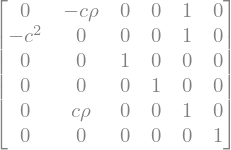

In [3]:
# compute the eigenvector matrix S
c = Symbol('c')
rho = Symbol('rho')
lambda_list = [eval for (eval, n, es) in F.left_eigenvects()]
Sinv_list = [[ev for ev in es] for (v, n, es) in F.left_eigenvects()]
Sinv = Matrix([Sinv_list[1][0],  Sinv_list[0][2], Sinv_list[0][0], Sinv_list[0][1], Sinv_list[2][0], Sinv_list[0][3]])
Sinv

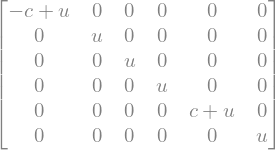

In [4]:
# compute eigenvalue matrix \lambda
lambda_waves = diag(lambda_list[1], lambda_list[0], lambda_list[0], lambda_list[0], lambda_list[2], lambda_list[0])
lambda_waves

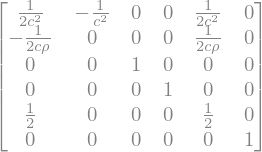

In [5]:
# compute S
S = Sinv.inv()
S

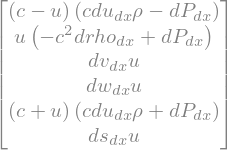

In [6]:
# compute the \mathcal{L} matrix

#drho_dx = Symbol(r'\frac{d\rho}{dx}')
#du_dx = Symbol(r'\frac{du}{dx}')
#dv_dx = Symbol(r'\frac{dv}{dx}')
#dw_dx = Symbol(r'\frac{dw}{dx}')
#dp_dx = Symbol(r'\frac{dP}{dx}')
#ds_dx = Symbol(r'\frac{ds}{dx}')

drho_dx = Symbol('drho_dx')
du_dx = Symbol('du_dx')
dv_dx = Symbol('dv_dx')
dw_dx = Symbol('dw_dx')
dp_dx = Symbol('dP_dx')
ds_dx = Symbol('ds_dx')

dQ_dx_def = Matrix([drho_dx, du_dx, dv_dx, dw_dx, dp_dx, ds_dx])
L = simplify(lambda_waves * Sinv * dQ_dx_def)
L

### x1 lower inflow (with relaxation term)

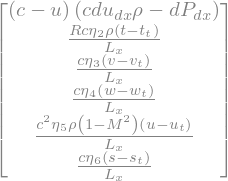

In [7]:
eta_2 = Symbol('eta_2')
eta_3 = Symbol('eta_3')
eta_4 = Symbol('eta_4')
eta_5 = Symbol('eta_5')
eta_6 = Symbol('eta_6')
Lx = Symbol('L_x')
M = Symbol('M')
u_t = Symbol('u_t')
v = Symbol('v')
v_t = Symbol('v_t')
w = Symbol('w')
w_t = Symbol('w_t')
s = Symbol('s')
s_t = Symbol('s_t')
t = Symbol('t') # gas temperature
t_t = Symbol('t_t')
R = Symbol('R') # gas constant (kB/mu)
L_inflow_x1_lower = Matrix([L[0],
                            eta_2*(c/Lx)*(rho*R)*(t-t_t),
                            eta_3*(c/Lx)*(v-v_t),
                            eta_4*(c/Lx)*(w-w_t),
                            eta_5*(rho*c**2 * (1 - M**2) / Lx)*(u - u_t),
                            eta_6*(c/Lx)*(s-s_t)])
L_inflow_x1_lower

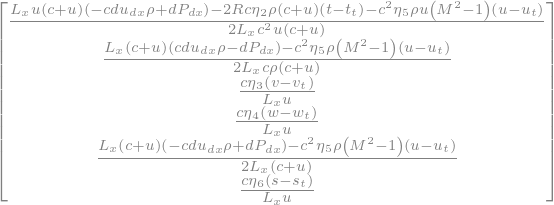

In [8]:
dQ_dx_inflow_x1_lower = simplify(S * Inverse(lambda_waves) * L_inflow_x1_lower)
dQ_dx_inflow_x1_lower

In [9]:
drho_dx = Symbol('drho_dx')
du_dx = Symbol('du_dx')
dv_dx = Symbol('dv_dx')
dw_dx = Symbol('dw_dx')
dp_dx = Symbol('dP_dx')
ds_dx = Symbol('ds_dx')
dQ_dx_def = Matrix([drho_dx, du_dx, dv_dx, dw_dx, dp_dx, ds_dx])
L = simplify(lambda_waves * Sinv * dQ_dx_def)

L_inflow_x1_lower = Matrix([L[0],
                            eta_2*(c/Lx)*(rho*R)*(t-t_t),
                            eta_3*(c/Lx)*(v-v_t),
                            eta_4*(c/Lx)*(w-w_t),
                            eta_5*(rho*c**2 * (1 - M**2) / Lx)*(u - u_t),
                            eta_6*(c/Lx)*(s-s_t)])

dQ_dx_inflow_x1_lower = simplify(S * Inverse(lambda_waves) * L_inflow_x1_lower)
print(cxxcode(dQ_dx_inflow_x1_lower, assign_to='dQ_dx'))

dQ_dx[0] = (1.0/2.0)*(L_x*u*(c + u)*(-c*du_dx*rho + dP_dx) - 2*R*c*eta_2*rho*(c + u)*(t - t_t) - std::pow(c, 2)*eta_5*rho*u*(std::pow(M, 2) - 1)*(u - u_t))/(L_x*std::pow(c, 2)*u*(c + u));
dQ_dx[1] = (1.0/2.0)*(L_x*(c + u)*(c*du_dx*rho - dP_dx) - std::pow(c, 2)*eta_5*rho*(std::pow(M, 2) - 1)*(u - u_t))/(L_x*c*rho*(c + u));
dQ_dx[2] = c*eta_3*(v - v_t)/(L_x*u);
dQ_dx[3] = c*eta_4*(w - w_t)/(L_x*u);
dQ_dx[4] = (1.0/2.0)*(L_x*(c + u)*(-c*du_dx*rho + dP_dx) - std::pow(c, 2)*eta_5*rho*(std::pow(M, 2) - 1)*(u - u_t))/(L_x*(c + u));
dQ_dx[5] = c*eta_6*(s - s_t)/(L_x*u);


### x1 lower inflow (with relaxation term; zero normal velocity)

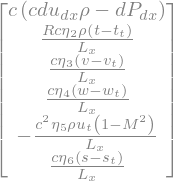

In [10]:
L_inflow_x1_lower_zerou = L_inflow_x1_lower.subs(u, 0)
L_inflow_x1_lower_zerou

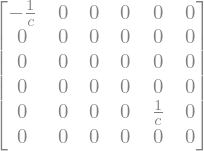

In [11]:
def pinv(x): # Moore-Penrose pseudoinverse of a diagonal matrix
    if x != 0:
        return x**-1
    else:
        return 0
ll = [pinv(l.subs(u,0)) for l in lambda_list]
linv_zerou = diag(ll[1], ll[0], ll[0], ll[0], ll[2], ll[0])
linv_zerou

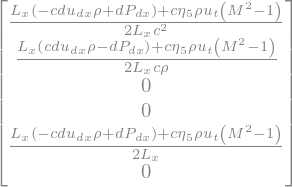

In [12]:
dQ_dx_inflow_x1_lower_zerou = simplify(S * linv_zerou * L_inflow_x1_lower_zerou)
dQ_dx_inflow_x1_lower_zerou

In [13]:
print(cxxcode(dQ_dx_inflow_x1_lower_zerou, assign_to='dQ_dx'))

dQ_dx[0] = (1.0/2.0)*(L_x*(-c*du_dx*rho + dP_dx) + c*eta_5*rho*u_t*(std::pow(M, 2) - 1))/(L_x*std::pow(c, 2));
dQ_dx[1] = (1.0/2.0)*(L_x*(c*du_dx*rho - dP_dx) + c*eta_5*rho*u_t*(std::pow(M, 2) - 1))/(L_x*c*rho);
dQ_dx[2] = 0;
dQ_dx[3] = 0;
dQ_dx[4] = (1.0/2.0)*(L_x*(-c*du_dx*rho + dP_dx) + c*eta_5*rho*u_t*(std::pow(M, 2) - 1))/L_x;
dQ_dx[5] = 0;
